In [1]:
import pandas as pd; pd.options.mode.chained_assignment = None # default warn => SettingWithCopyWarning
import numpy as np
import warnings; warnings.simplefilter(action='ignore', category=UserWarning)
from IPython.display import HTML, display
from ipywidgets import AppLayout, Button, Layout, VBox, HBox, Label, HTML, interact
import ipywidgets as widgets
import arrow

import dmyplant2
dmyplant2.cred()
mp = dmyplant2.MyPlant(3600)
from dmyplant2 import msgFSM, FSMPlot_Start, bokeh_show, dbokeh_chart

In [2]:
def sfun(x):
    return all([
            ("Forsa Hartmoor" in str(x['IB Site Name'])), 
            (x['OperationalCondition'] != 'Decommissioned')
        ])

In [3]:
fleet = mp.search_installed_fleet(sfun).drop('index', axis=1)
fleet = fleet.sort_values(by = "Engine ID",ascending=True).reset_index(drop='index')
pname = 'persist.json'
try:
    persist_dialog = dmyplant2.load_json(pname)
except FileNotFoundError:        
    persist_dialog = {
        'dl': 0,
        'modes': [
                {'name':'???','value':False },
                {'name':'OFF','value':False },
                {'name':'MANUAL','value':False},
                {'name':'AUTO','value':True }],
        'starts': [   
                {'name':'True','value':True },
                {'name':'False','value':False }]   
    }
    dmyplant2.save_json(pname,persist_dialog)

In [4]:
    fleet.T;

In [5]:
# Dialog
persist_dialog = dmyplant2.load_json(pname)
ddl = pd.DataFrame(fleet['serialNumber'] + ' - ' + fleet['IB Site Name'] + ' ' + fleet['Engine ID'])[0].to_list()
ddl = [(m, i) for i, m in enumerate(ddl)]
#dl=widgets.Dropdown(options = ddl,value=0,description='Engine:',layout={'width':'max-content'},disabled=False)
dl=widgets.Dropdown(options = ddl,value=persist_dialog['dl'],description='Engine:',layout={'width':'auto'},disabled=False)
out = widgets.Output(layout={'height':'auto', 'width':'auto'})
rmodes = persist_dialog['modes']
service_selector_modes = [] 
modes = []
for mm in rmodes:
    service_selector_modes.append(widgets.Checkbox(
        value=mm['value'], 
        description=mm['name'],
        layout={'width':'auto'},
        disabled=False,indent=False))

rsucc = persist_dialog['starts']
successful_starts = []; 
for rs in rsucc:
    successful_starts.append(widgets.Checkbox(
            value=(str(rs['value']) == rs['name']),
            description=rs['name'],
            layout={'width':'auto'},
            disabled=False,indent=False))

app = AppLayout(  header=dl,
            #left_sidebar=Button(description='center', button_style='warning', layout=Layout(height='auto', width='auto')),
            left_sidebar=None,
            center=HBox([
                VBox(service_selector_modes),
                VBox(successful_starts),
                out
            ]),
            right_sidebar=None,
            footer = None,
            #footer = Button(description='footer', button_style='success', layout=Layout(height='auto', width='auto')),
            pane_widths=['10px',1,'10px'],
            pane_heights=['40px','250px','40px']
            )
display(app)

AppLayout(children=(Dropdown(description='Engine:', index=3, layout=Layout(grid_area='header', width='auto'), …

In [6]:
# Load Engine Data and execute FSM Run 1 - display Results 
persist_dialog = {
    'dl':dl.value, 
    'modes': [{'name':cb.description, 'value':cb.value} for cb in service_selector_modes],
    'starts': [{'name':cb.description, 'value': str(cb.value) == cb.description} for cb in successful_starts]}
dmyplant2.save_json(pname,persist_dialog)
e=dmyplant2.Engine.from_fleet(mp,motor:=fleet.iloc[dl.value])
fsm = msgFSM(e, p_from=e['Commissioning Date'], p_to=arrow.now(), frompickle=True)
fsm.run1(enforce=False) # run Finite State Machine
fsm.store()

In [7]:
out.clear_output()
with out:
    fsm.summary_out()
rdf = fsm.result
#rdf[fsm.filters['filter_content']].round(2)
modes = [rmodes[i]['name'] for i,v in enumerate(service_selector_modes) if v.value]
success = [rsucc[i]['value'] for i,v in enumerate(successful_starts) if v.value]
rda = rdf[:].reset_index(drop='index')
rda['count_alarms'] = rda.apply(lambda x: len(x['alarms']), axis=1)
rda['count_warnings'] = rda.apply(lambda x: len(x['warnings']), axis=1)
rda = rda[(rda['mode'].isin(modes) & rda['success'].isin(success))]
display(HTML(pd.DataFrame.from_dict(e.dash, orient='index').T.to_html(escape=False, index=False)))
print(modes, success)
#rda[fsm.filters['run2filter_content'] + fsm.filters['filter_alarms_and_warnings']].round(2)

HTML(value='<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th>Na…

['???', 'OFF', 'MANUAL', 'AUTO'] [True, False]


In [8]:
# Execute FSM Run 2
rda = fsm.run2(rda)
fsm.store()

FSM Run2: 100%|█████████████████████████| 85/85 [00:00<00:00, 11856.99 starts/s]


In [9]:
fsm._starts;

In [10]:
rdb = rda
#rdb = rda[(rda['mode'].isin(['AUTO','MANUAL'])) & ((rda['count_alarms'] > 0) | (rda['count_warnings'] > 0))]
#rdb = rda[rda['synchronize'] < 15.0]
rdb[fsm.filters['run2filter_content'] + fsm.filters['filter_alarms_and_warnings']].round(2)

,index,success,mode,startpreparation,starter,hochlauf,idle,synchronize,loadramp,cumstarttime,maxload,ramprate,targetoperation,coolrun,count_alarms,count_warnings
0,0,True,???,97.95,4.24,24.00,6.35,13.02,130.69,276.25,4512.00,0.77,17846.04,58.57,0,0
1,1,True,???,92.73,3.84,20.03,5.56,28.36,127.20,277.72,4473.37,0.78,711.43,58.81,0,0
2,2,False,MANUAL,442.40,NaN,NaN,NaN,NaN,NaN,442.40,4504.35,NaN,NaN,NaN,0,0
3,3,True,AUTO,76.68,3.84,21.80,5.54,24.14,128.53,260.52,4484.49,0.78,381.94,58.64,0,0
4,4,False,AUTO,106.12,4.14,21.08,NaN,NaN,NaN,131.34,4519.00,NaN,NaN,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,80,True,AUTO,99.20,4.04,20.57,4.34,32.11,119.85,280.11,4510.00,0.84,12748.62,58.94,0,0
81,81,True,AUTO,97.63,4.24,23.00,4.45,4.13,145.69,279.14,4499.32,0.69,7355.71,58.84,0,0
82,82,True,AUTO,97.46,4.04,21.09,4.25,33.71,119.26,279.81,4509.75,0.84,1949.36,59.02,0,0
83,83,False,AUTO,101.49,4.04,44.01,NaN,NaN,NaN,149.54,4491.96,NaN,NaN,NaN,0,0


,startpreparation,hochlauf,idle,synchronize,loadramp,maxload,ramprate,cumstarttime,targetoperation,coolrun
count,85.00,78.00,70.00,70.00,70.00,85.00,70.00,85.00,69.00,69.00
mean,113.23,21.74,4.88,19.21,144.59,4202.36,0.73,275.74,7115.13,59.00
std,78.51,4.01,0.68,14.95,64.80,1097.44,0.11,91.20,5942.21,0.33
min,4.84,3.23,4.04,1.11,105.11,0.00,0.15,4.84,242.16,58.24
25%,96.23,19.79,4.34,4.43,127.52,4491.04,0.69,276.57,1949.36,58.74
50%,98.52,21.51,4.60,11.76,132.98,4499.00,0.75,279.14,5551.18,58.94
75%,100.90,23.61,5.45,33.81,144.55,4506.49,0.78,280.85,10956.01,59.26
max,489.45,44.01,6.37,42.48,654.25,4533.00,0.95,792.87,20656.61,60.06


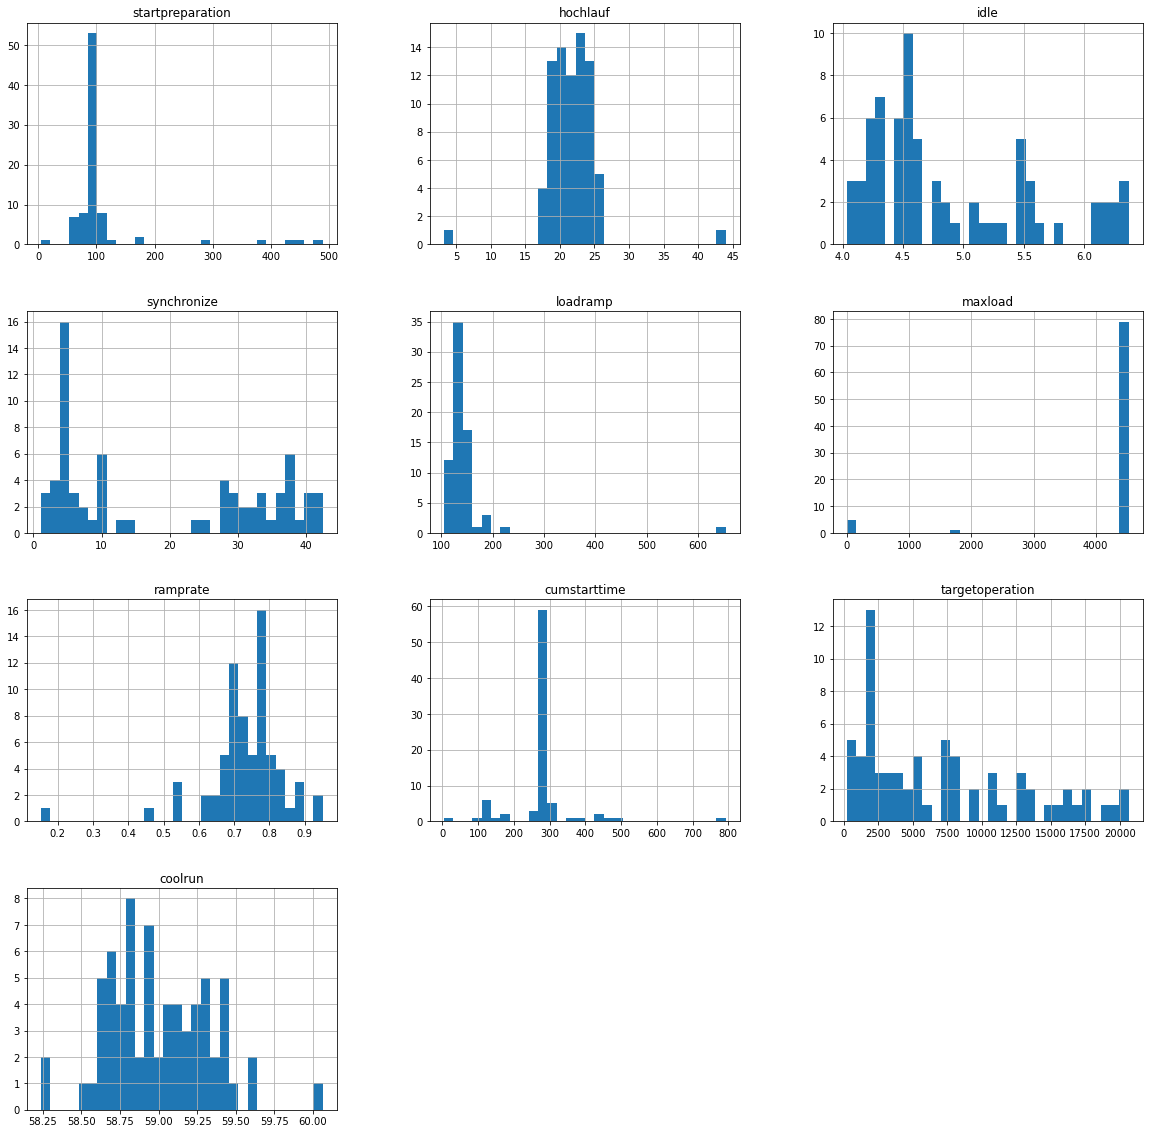

In [11]:
display(_=rdb[['startpreparation','hochlauf','idle','synchronize','loadramp','maxload','ramprate','cumstarttime','targetoperation','coolrun']].hist(bins=30,figsize=(20,20)))
display(rdb[['startpreparation','hochlauf','idle','synchronize','loadramp','maxload','ramprate','cumstarttime','targetoperation','coolrun']].describe().round(2))

In [12]:
vset = fsm._data_spec + ['Hyd_PressCrankCase','Hyd_PressOilDif','Hyd_PressOil','Hyd_TempOil']
dset = [
    {'col':['Power_PowerAct'], 'ylim':(0,5000), 'color':'red'},
    {'col':['Various_Values_SpeedAct'],'ylim': [0, 2500], 'color':'blue'},
    #{'col':['Hyd_PressCrankCase'],'ylim': [-100, 100], 'color':'orange'},
    #{'col':['Hyd_PressOilDif'],'ylim': [0, 2], 'color':'black'},
    {'col':['Hyd_PressOil'],'ylim': [0, 10], 'color':'brown'},
    {'col':['Hyd_TempOil'],'ylim': [0, 110], 'color':'#2171b5'}
]
dfigsize = (16,10)

In [13]:
def f(x=0):
    global v; v = x; startversuch = rdb.iloc[x]
    ftitle = f"{fsm._e} ----- Start {startversuch['index']} {startversuch['mode']} | {'SUCCESS' if startversuch['success'] else 'FAILED'} | {startversuch['starttime'].round('S')}"
    display(HTML(ftitle));
    return fsm.disp_result(startversuch)
interact(f, x = (0, rdb.shape[0]-1));

interactive(children=(IntSlider(value=0, description='x', max=84), Output()), _dom_classes=('widget-interact',…

In [14]:
fig = FSMPlot_Start(fsm,rdb.iloc[v], vset, dset, figsize=dfigsize); bokeh_show(fig); fig.renderers = []

von: 11.01.2022 09:54:21 bis: 11.01.2022 14:57:18


In [ ]:
startversuch = rdb.iloc[v]
td = {k:v for k,v in startversuch.items() if k.endswith('_time')}

display(HTML(pd.DataFrame.from_dict(dict(zip(fsm.filters['vertical_lines_times'], fsm.states_lines(startversuch))), orient='index').T.to_html(escape=False,index=False)))
display(HTML(pd.DataFrame.from_dict(td,orient='index').T.to_html(escape=False,index=False)))

In [ ]:
tl = [startversuch[k] for k in startversuch.keys() if k.endswith('_time')]
tl

In [ ]:
rde = rda[(rda.starttime > fsm._e['Commissioning Date']) & (rda['success']) & (rda['maxload'] > 4000.0)].copy()
rde['datetime'] = pd.to_datetime(rde['starttime'])
dset = [
    {'col':['cumstarttime'],'ylim':(-400,900), 'color':'darkblue'},
    {'col':['synchronize'],'ylim':(-50,650)},
    {'col':['startpreparation'],'ylim':(-600,300)},
    {'col':['hochlauf'],'ylim':(-100,200), 'color':'orange'},
    {'col':['loadramp'],'ylim':(-150,900), 'color':'red'},
    {'col':['ramprate'],'ylim':(-3,3)},
    {'col':['index'],'color':'black'},
    {'col':['maxload'],'ylim':(500,5000) }
]
ftitle = f"{fsm._e}"
fig = dbokeh_chart(rde, dset, style='circle', figsize=dfigsize ,title=ftitle);
bokeh_show(fig)
fig.renderers = []

In [ ]:
nalarms = []
ct = 0
ct2 = 0
mini = 0
maxi = 100
_txt = ''
for i,c in rdf.iterrows():
    if len(c['alarms']) > 0 and not c['success']:
        ct += 1
        _txt += f"<h3>Startversuch: {i}, Success: {c['success']}</h3>"
        #display(HTML(f"\n<hr><h3>Startversuch: {i}, Success: {c['success']}</h3>"))
        print()
        for a in c['alarms']:
            nalarms.append(a['msg'])
            _txt += f"{ct2} {c['mode']:15} {a['state']:20} " + fsm.msgtxt(a['msg']) + "<br>"
            #_txt = f"{ct2} {c['mode']:15} {a['state']:20} {a['msg']['timestamp']} {pd.to_datetime(int(a['msg']['timestamp'])*1e6).strftime('%d.%m.%Y %H:%M:%S')} {a['msg']['name']} {a['msg']['message']}"
            #if ct2 >= mini and ct2 <= maxi:
                #fsm.plot_cycle(c, ylim=(0,2500), cycletime=1, marker=None,figsize=(20,12), title=f"{i:3d} - {fsm._e} {_txt}")
                #plt.show()
            ct2 += 1
_txt = f"<h2>{fsm._e}, <br>{ct:3} not successful starts</h2>" + _txt
display(HTML(_txt))


In [ ]:
phases = [['startpreparation','starter','hochlauf','idle','synchronize','loadramp','targetoperation','coolrun'],'startpreparation','starter','hochlauf','idle','synchronize','loadramp','targetoperation','coolrun']
for phase in phases:
    al = fsm.alarms_pareto(phase)
    if not al.empty:
        display(HTML(f"<h3>{phase}:</h3>"))
        al.sort_values(by = "anz",ascending=True)
        display(HTML(al.to_html(escape=False, index=False)))

In [ ]:
for phase in phases:
    wr = fsm.warnings_pareto(phase)
    if not wr.empty:
        display(HTML(f"<h3>{phase}:</h3>"))
        wr.sort_values(by = "anz",ascending=True)
        display(HTML(wr.to_html(escape=False, index=False)))

In [ ]:
mfn = e._fname + '_messages.txt'
fsm.save_messages(mfn)
print(mfn)

In [ ]:
lfn = e._fname + '_runlog.txt'
fsm.save_runlog(lfn)
print(lfn)